---
# 1 Introducción

El siguiente cuaderno aplica una función sinusoidal simple a cada uno de los elementos del array, mostrando posteriormente el resultado en un gráfico de ejes cartesianos. El algoritmo se basa en la función:

 <center>$f(x) = A * Sen(2\pi f * x + \theta)$</center>  

Se pueden definir las variables $A = Amplitud$, $f = frecuencia$, y $\theta = Desface$, asi como también la cantidad de muestras a tomar para aplicarles la funcion.

El cuaderno tiene dos secciones, en la primera vamos a ejecutar el algoritmo de manera secuencial con el CPU. Va a recorrer cada uno de los elementos del array, aplicandole la funcion seno, obteniendo el valor resultante y guardandolo en otro array. Posteriormente se mostrará en un "plot".

En la segunda seccion podremos ejecutar el mismo algoritmo pero haciendo uso de la GPU a través de "CUDA", se van a ejecutar distintos threads paralelamente que accederán al valor que les corresponda del array, aplicarán la funcion seno, guardarán el resultado, y finalizarán su ejecución. Posteriormente, una vez aplicada la función, se mostrará en un "plot" al igual que el algoritmo que corre en CPU.

---
# 2 Armado del ambiente


In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 14.9MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 81kB 13.7MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=dbbd7ddb68e2079ff039bb407f916d5d23da2cc63d11b2a69fabc3435218915d
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=1d0bfa4096f900b67dc92dd2d68308711a768d73d2297186a1b814e5e248c461
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


---
# 3 Desarrollo


# CPU

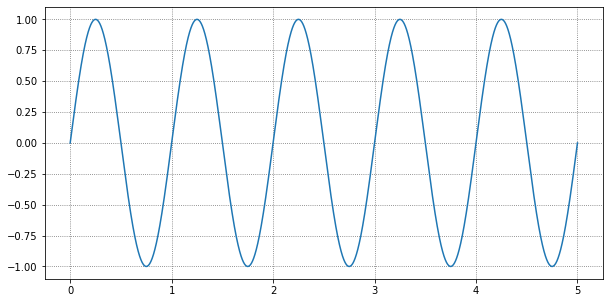

Tiempo Total:  1116.28 [ms]
Tiempo bucle:  878.692 [ms]


In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cantidad_N =    1000000#@param {type: "number"}
amplitud =      1#@param {type: "number"}
desface =       0#@param {type: "number"}
frecuencia =    1#@param {type: "number"}

# --------------------------------------------

from datetime import datetime
tiempo_total = datetime.now()

import numpy
import matplotlib.pyplot as plt 
import math

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# --------------------------------------------
# CPU - Defino la memoria de los vectores en cpu.
try:
  x = numpy.linspace(0, 5, cantidad_N) 
except ValueError:
  sys.exit("La cantidad N no puede ser menor a 0")
y = numpy.zeros_like(x)

# El resultado se escribe sobre el mismo vector Y.

# --------------------------------------------
# CPU - Realizo la función sinusoidal simple.

tiempo_bucle = datetime.now()

for key in range(0, cantidad_N):
  # aplico la funcion sinusoidal (y = A * Sen(2pi*f*x+desface))
  y[key] = amplitud * math.sin(2 * math.pi * frecuencia * x[key] + desface)

tiempo_bucle = datetime.now() - tiempo_bucle

fig = plt.figure(figsize = (10, 5)) 
# Create the plot 
plt.plot(x, y) 

plt.grid(b=True, which='major', color='#666666', linestyle='dotted')
  
# Show the plot 
plt.show() 

# -------------------------------------------

tiempo_total = datetime.now() - tiempo_total

print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo bucle: ", tiempo_en_ms( tiempo_bucle ), "[ms]" )


# GPU

Thread x:  256 , Bloque x: 3907


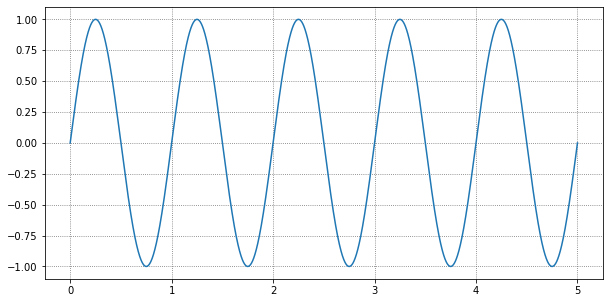

Cantidad de elementos:  1000000
Thread x:  256 , Bloque x: 3907
Tiempo Total:  221.799 [ms]
Tiempo GPU:  0.615 [ms]


In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cantidad_N =    1000000#@param {type: "number"}
amplitud =      1#@param {type: "number"}
desface =       0#@param {type: "number"}
frecuencia =    1#@param {type: "number"}
# --------------------------------------------

from datetime import datetime
import sys

try :
  import pycuda.driver as cuda
except ModuleNotFoundError:
  sys.exit("No se pudo importar el paquete de cuda, primero debe ejecutar el comando que lo descarga en la sección de armado del ambiente")

import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import matplotlib.pyplot as plt 
import math

tiempo_total = datetime.now()
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0


# CPU - Defino la memoria de los vectores en cpu.

try:
  x_cpu = numpy.linspace(0, 5, cantidad_N) 
except ValueError:
  sys.exit("La cantidad N no puede ser menor a 0")
x_cpu = x_cpu.astype(numpy.float32())

#tiempo_ini_cpu = datetime.now()

r_cpu = numpy.empty_like( x_cpu )

# CPU - reservo la memoria GPU.
x_gpu = cuda.mem_alloc( x_cpu.nbytes )
y_gpu = cuda.mem_alloc( r_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( x_gpu, x_cpu )
cuda.memcpy_htod( y_gpu, r_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_seno( int n, float amplitud, float frecuencia, float desface, float *X, float *Y )
{
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  if( idx < n )
  {
    Y[idx]  = amplitud * sin(2 * M_PI * frecuencia * X[idx] + desface);
  }
}
""") 
# CPU - Genero la función kernel.
kernel = module.get_function("kernel_seno")

tiempo_gpu = datetime.now()

# GPU - Ejecuta el kernel.
dim_hilo = 256
dim_bloque = numpy.int( (cantidad_N+dim_hilo-1) / dim_hilo )
print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

kernel( numpy.int32(cantidad_N),numpy.float32(amplitud),numpy.float32(frecuencia),numpy.float32(desface), x_gpu, y_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( r_cpu, y_gpu )

fig = plt.figure(figsize = (10, 5)) 
# Create the plot 
plt.plot(x_cpu, r_cpu) 

plt.grid(b=True, which='major', color='#666666', linestyle='dotted')
  
# Show the plot 
plt.show() 

tiempo_total = datetime.now() - tiempo_total

print( "Cantidad de elementos: ", cantidad_N )
print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU: ", tiempo_en_ms( tiempo_gpu   ), "[ms]" )

---
#4 Tabla de pasos
Tabla de pasos de la ejecución del programa:

# Versión CPU
 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param                | Lectura de variables Amplitud,Desface,Frecuencia, y cantidad de muestras.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo inicial.
CPU      |  numpy.linspace( 0, 5, cantidad_N ) | Inicializo el vector x, se le asignan los valores de forma aleatoria entre 0 y 5 (la cantidad de valores a asignar es la elegida anteriormente).
CPU      |  for...                | Aplico la función sinusoidal y guardo los valores en el vector y
CPU      |  datetime.now()        | Toma el tiempo final.
CPU      |  plt.show()                 | Muestra los valores en forma gráfica por pantalla.

# Versión GPU

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param                | Lectura de variables Amplitud,Desface,Frecuencia, y cantidad de muestras.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo inicial.
CPU      |  numpy.linspace( 0, 5, cantidad_N ) | Inicializo el vector x, se le asignan los valores de forma aleatoria entre 0 y 5 (la cantidad de valores a asignar es la elegida anteriormente).
**GPU**      | cuda.mem_alloc( )      | Reservo memoria del gpu del mismo tamaño del array x, para poder transferirle los datos 
**GPU**      | cuda.memcpy_htod()     | copio datos desde la memoria principal hacia la memoria del GPU
CPU      | SourceModule           | defino el kernel que correra en GPU (que aplica la función seno y guarda el resultado de manera paralela)
CPU      | module.getFunction()   | Genera la función del kernel GPU
CPU      | dim_tx/dim_bx          | calculo las dimensiones
**GPU**      | kernel()               | corro el kernel en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde la memoria del GPU a memoria principal.
CPU      |  plt.show()            | Muestra los valores en forma gráfica por pantalla.




---
# 5 Conclusiones

Como conclusión podemos observar algunos aspectos


*   El algoritmo empieza a mostrar por pantalla una funcion con presición aceptable luego de un número de muestras superior a 1000.
*   Con muestras del nivel de 1000 ya obtenemos una diferencia en velocidades, el proceso secuencial de la cpu tarda 1 ms en ejecutar el ciclo de repetición.
Mientras que cuando se ejecuta paralelamente en GPU, esa sección demora 0,4ms
*   Si queremos ir más alla, y queremos utilizar una muestra mas grande, la latencia de respuesta en el algoritmo secuencial crece linealmente, con 1000000 de elementos de muestra se demora 916ms, mientras que su equivalente en GPU demora poco más que antes, 0,68ms.

Para resumir, la diferencia mas grande en cuanto a tiempo de respuesta se ve al aumentar el número de muestras a valores cercanos a 1.000.000, aquí ya vemos que la ejecución secuencial por CPU tarda 1300 veces más que su equivalente en CPU (0,68ms vs 916ms).

Seria interesante a futuro observar con rangos de dominio de la función mas grandes. Aqui estamos probando con números entre 0 y 5, y no hace falta un N muy grande para que la representación gráfica sea fiel. Si se probase con un dominio mas grande (Ej. [-100, 100]), tal vez obligadamente se necesite tener un N muy grande para que la representación visual sea suficientemente precisa. En ese contexto, la versión de GPU sería la única capaz de hacerlo de forma rápida.



---
# 6 Bibliografía

[1] Sinusoide : [Wikipedia](https://es.wikipedia.org/wiki/Sinusoide)

[2] Sinusoide : [GeoGebra](https://www.geogebra.org/m/uygjgeh5)

[3] Cuda : [Documentacion](https://docs.nvidia.com/cuda/)